In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
import lightgbm as lgb
import numpy as np
from sklearn import metrics
rcParams['figure.figsize'] = 10,8

In [29]:
pdf = pd.read_csv('advertising/advertising.csv')

In [30]:
pdf.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [31]:
pdf.shape

(1000, 10)

### 特徴量作成

In [52]:
#DUMMY_COLS = ['Ad Topic Line', 'City', 'Country']
EXCLUDE_COLS = ['Timestamp', 'Ad Topic Line', 'City', 'Country']
TARGET_COL = 'Clicked on Ad'
USE_COLS = list(set(pdf.columns) - set(EXCLUDE_COLS) - set([TARGET_COL]))

In [53]:
USE_COLS

['Male',
 'Daily Time Spent on Site',
 'Area Income',
 'Age',
 'Daily Internet Usage']

In [54]:
pdf_x = pdf[USE_COLS]
pdf_y = pdf[TARGET_COL]

In [55]:
pdf_x.head()

,Male,Daily Time Spent on Site,Area Income,Age,Daily Internet Usage
0,0,68.95,61833.90,35,256.09
1,1,80.23,68441.85,31,193.77
2,0,69.47,59785.94,26,236.50
3,1,74.15,54806.18,29,245.89
4,0,68.37,73889.99,35,225.58


In [56]:
pdf_y.head()

0    0
1    0
2    0
3    0
4    0
Name: Clicked on Ad, dtype: int64

### モデル構築

#### LightGBM

In [63]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 2,
        'learning_rate': 0.1,
        'num_leaves': 23,
        'min_data_in_leaf': 1,
        'num_iteration': 100,
        'verbose': 0
}

accuracy : 0.9551


<Figure size 720x576 with 0 Axes>

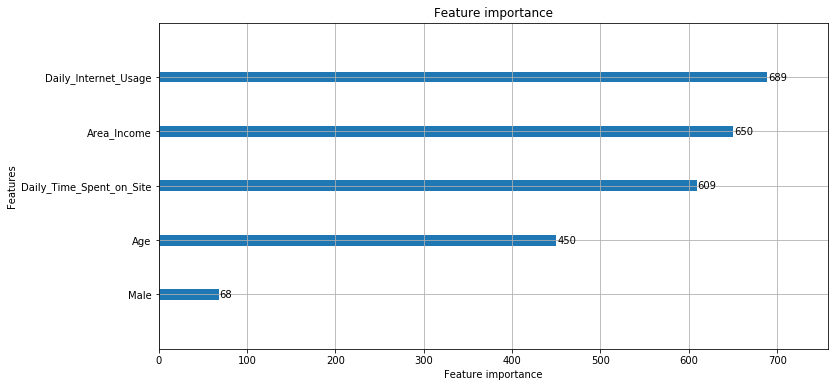

auc : 0.9551
accuracy : 0.9431


<Figure size 720x576 with 0 Axes>

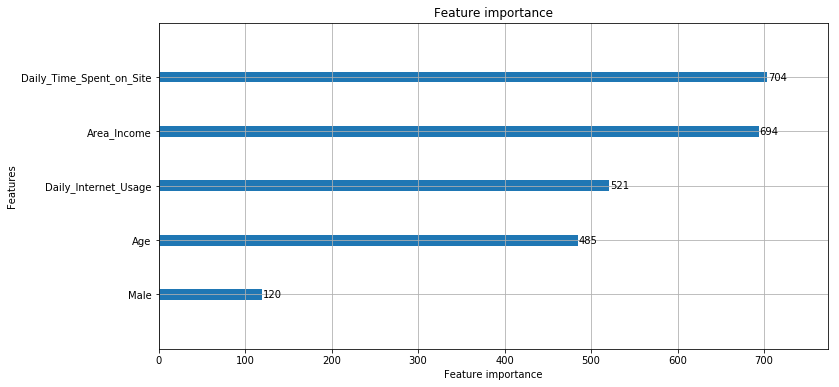

auc : 0.9431
accuracy : 0.9759


<Figure size 720x576 with 0 Axes>

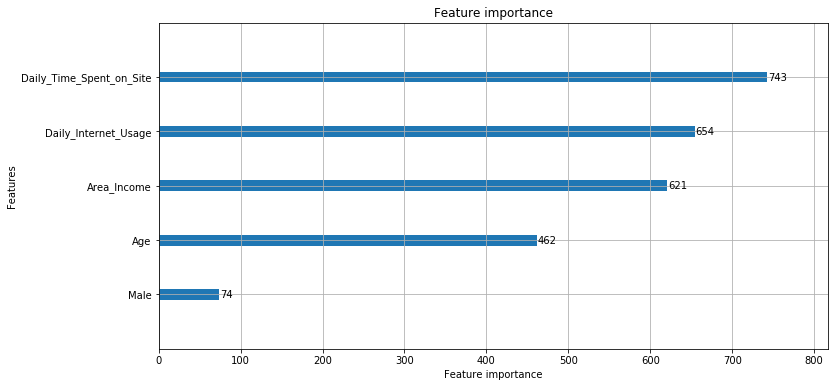

auc : 0.9759


In [80]:
kf = StratifiedKFold(n_splits=3, shuffle=True)
for train_index, test_index in kf.split(pdf_x, pdf_y):
    gbm = lgb.LGBMClassifier()
    
    X_train, X_test = pdf_x.iloc[train_index], pdf_x.iloc[test_index]
    y_train, y_test = pdf_y.iloc[train_index], pdf_y.iloc[test_index]
    
    gbm.fit(
        X_train, 
        y_train
    )

    y_pred_proba = gbm.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = sum(y_test == y_pred) / len(y_test)
    print('accuracy : {:.4f}'.format(accuracy))

    plt.clf()
    lgb.plot_importance(gbm, figsize=(12, 6))
    plt.show()
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print('auc : {:.4f}'.format(auc))
    
    print('='*100)